This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/lyapunov.html).  I recommend having both windows open, side-by-side!


In [1]:
from sys import platform

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from pydrake.all import (
    CsdpSolver,
    RegionOfAttraction,
    RegionOfAttractionOptions,
    SolverOptions,
    SymbolicVectorSystem,
    Variable,
    plot_sublevelset_expression,
)

from underactuated import plot_2d_phase_portrait, running_as_notebook

if running_as_notebook:
    mpld3.enable_notebook()

# Estimated regions of attraction need not be convex regions (in state space)

To demonstrate that, let's make a system with a known, non-convex region of attraction.  We'll do this by taking some interesting potential function $U(x) \in SOS$ and setting the dynamics to be $\dot{x} = (U(x)-1) \frac{\partial U}{\partial x}^T$, which has $U(x) <= 1$ as the region of attraction.  

Slightly more general is to write $\dot{x} = (U(x)-1) {\bf R}(\theta) \frac{\partial U}{\partial x}^T$, where ${\bf R}(\theta) = \begin{bmatrix} \cos\theta & \sin\theta \\ -\sin\theta & \cos\theta\end{bmatrix}$ is the 2D rotation matrix, and $\theta<\pi$ is a constant parameter (not a decision variable nor indeterminate), which still has the same region of attraction.

**Note: This example is (currently) broken when using Mosek as the SDP solver.**  The estimated region of attraction is actually outside the known region of attraction!  This is due to some subtle numerical issues in the solver.  I've left it in as honest and educational, but we are working to make the solver pre-processing more robust to examples like this.  See [Drake Issue #12876](https://github.com/RobotLocomotion/drake/issues/12876).

SystemExit: Failure at external/drake+/systems/analysis/region_of_attraction.cc:107 in FixedLyapunovConvex(): condition 'result.is_success()' failed.

/Users/russt/underactuated/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


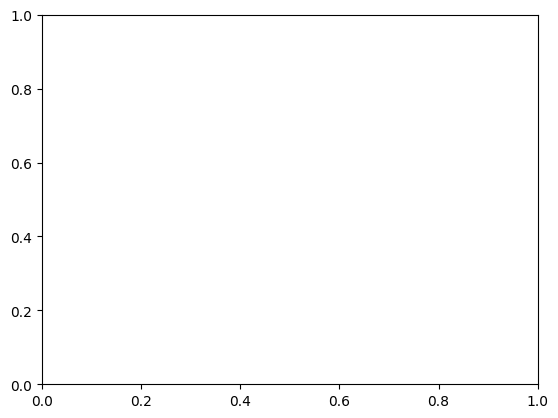

In [ ]:
def star_convex():
    # Construct a non-convex 2D level set.
    x = np.array([Variable("x"), Variable("y")]).reshape((2,))
    A1 = np.array([[1, 2], [3, 4]])
    A2 = A1 @ np.array([[-1, 0], [0, 1]])  # mirror about y-axis
    U = (x.T.dot(A1.T.dot(A1.dot(x)))) * (x.T.dot(A2.T.dot(A2.dot(x))))

    fig, ax = plt.subplots()

    theta = 0.5
    np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    dUdx = U.Jacobian(x)
    sys = SymbolicVectorSystem(state=x, dynamics=(U - 1) * dUdx.T)
    context = sys.CreateDefaultContext()

    options = RegionOfAttractionOptions()
    options.lyapunov_candidate = x.dot(x)
    options.state_variables = x
    # Force the use of CSDP for solving; Mosek and Clarabel are known to fail for
    # this test, see #12876.
    options.solver_id = CsdpSolver.id()
    options.solver_options = SolverOptions()
    if platform == "darwin":
        return  # this is now breaking on my mac...
        # We also need a tighter tolerance to pass on macOS.
        # https://github.com/RobotLocomotion/drake/pull/21135
        # but it does give false confidence.
        options.solver_options.SetOption(CsdpSolver.id(), "objtol", 1e-9)
    V = RegionOfAttraction(sys, context, options)
    plot_sublevelset_expression(ax, V)
    plot_sublevelset_expression(ax, U, 101, linewidth=3, fill=False)

    plot_2d_phase_portrait(sys, (-0.8, 0.8), (-0.6, 0.6))


star_convex()